A notebook for viewing extracted rois in the context of the original video

In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
import copy
from pathlib import Path
import pickle

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pyspark

from janelia_core.dataprocessing.roi import ROI
from janelia_core.dataprocessing.utils import get_processed_image_data
from janelia_core.fileio.exp_reader import find_images

In [3]:
%matplotlib notebook

## Parameters go here

In [27]:
# The base folder containing the individual image folders 
image_folder = r'K:/SV4/CW_18-02-15/L1-561nm-openLoop_20180215_163233.corrected/Results/WeightFused'

# The extension for the raw images
image_ext = r'weightFused.TimeRegistration.klb'

# The folder containing extracted ROI results
roi_folder = r'K:\SV4\CW_18-02-15\L1-561nm-openLoop_20180215_163233.corrected\extracted\rois_segments'

# File containg roi locations
roi_location_file = 'roi_locs.pkl'

# File containing extracted fluorescence
roi_f_file = 'extracted_f.h5'

# The number of time points we examine
n_tm_pts = 100

# Specify the index of the roi we want to look at
roi_ind = 10151

## Create a pyspark context

In [5]:
conf = pyspark.SparkConf().setMaster('local[20]').setAll([
    ('spark.executor.memory', '10g'), ('spark.driver.memory','400g'), ('spark.driver.maxResultSize', '300g')])
sc = pyspark.SparkContext(conf=conf)

## Find all image files

In [6]:
imgs = find_images(image_folder=Path(image_folder), image_ext=image_ext, image_folder_depth=1)

Searching for image files...
Found 10367 images.


## Load ROI locations

And pull out the ROI we will be specifically looking at

In [7]:
with open(Path(roi_folder) / roi_location_file, 'rb') as f:
    roi_locs = pickle.load(f)

roi_locs = [ROI.from_dict(d) for d in roi_locs]


In [8]:
roi = roi_locs[roi_ind]

## Load the extracted fluorescence for each roi

In [39]:
with h5py.File(Path(roi_folder) / roi_f_file, 'r') as f:
        extracted_f = f['data'][:]

## Load the z-planes of images for the ROI we are interested in

In [9]:
z_planes = np.unique(roi.voxel_inds[0])
print('z_planes: ' + str(z_planes))

z_planes: [67 68 69]


In [10]:
def get_z_planes_(img):
    return img[z_planes, :, :]

imgs = get_processed_image_data(imgs[0:n_tm_pts], get_z_planes_, sc=sc)

## Get a max projection of the images through time

In [11]:
max_projs = np.asarray([np.max(im, axis=0) for im in imgs])

## Get the max through time of our max projections - this is to help us see where cell bodies our

In [12]:
max_img = np.max(max_projs, axis=0)

## View the max projection through time to see where cell bodies are

<IPython.core.display.Javascript object>


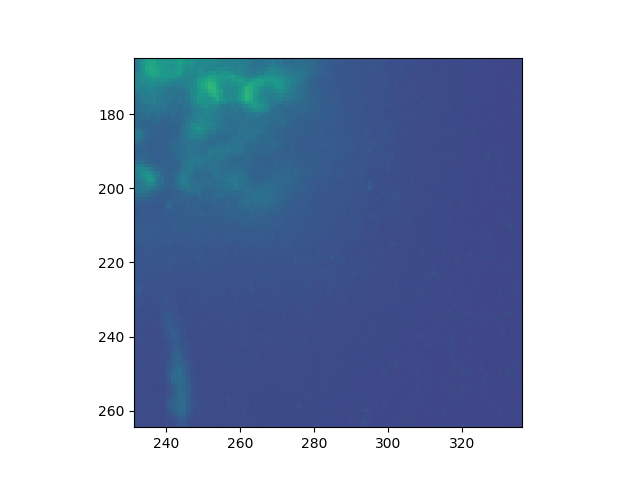

In [13]:
plt.figure()
plt.imshow(max_img)

Now we make the same plot but also show where the roi is

<IPython.core.display.Javascript object>


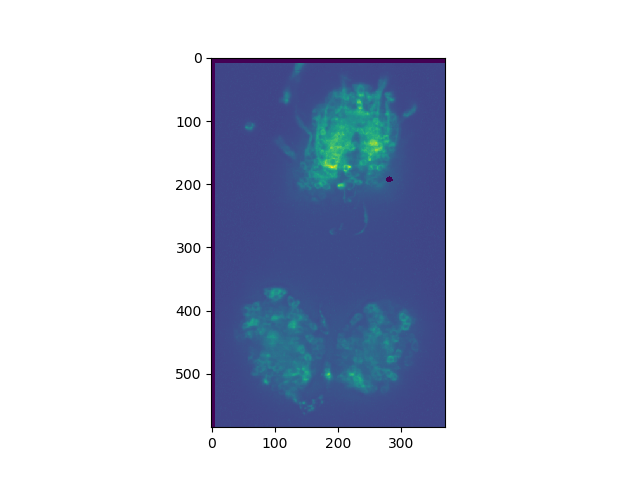

In [14]:
roi_figure = np.zeros(max_img.shape)
roi_figure[:] = np.nan
roi_figure[roi.voxel_inds[1], roi.voxel_inds[2]] = 1

plt.figure()
plt.imshow(max_img)
plt.imshow(roi_figure)

In [20]:
voxel_inds = list(copy.deepcopy(roi.voxel_inds))
voxel_inds[0] = voxel_inds[0] - np.min(voxel_inds[0]) 
voxel_inds = tuple(voxel_inds)

In [24]:
new_f = np.asarray([np.mean(img[voxel_inds]) for img in imgs])

<IPython.core.display.Javascript object>


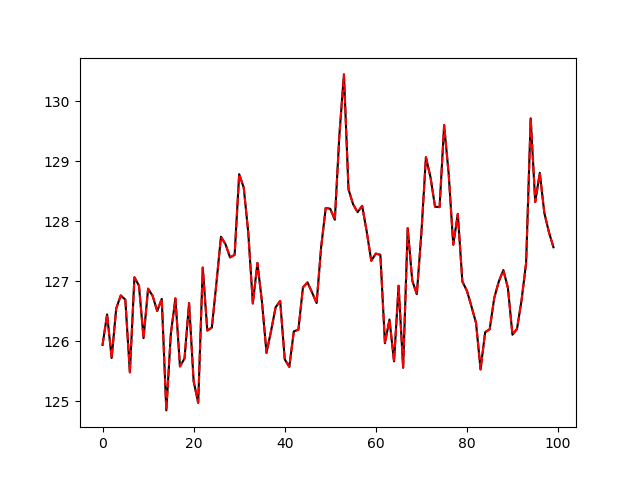

In [43]:
plt.figure()
plt.plot(new_f, 'k-')
plt.plot(extracted_f[0:n_tm_pts, roi_ind], 'r--')